In [14]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Create figures directory

sns.set_style("whitegrid")

## Load results

In [15]:
# Load predictions and metrics
with open("../results/cv_results.json", "r") as f:
    cv_results = json.load(f)

df_folds = pd.read_csv("../results/metrics_by_fold.csv")
df_summary = pd.read_csv("../results/metrics_summary.csv", index_col=0)

print(f"Models: {list(cv_results.keys())}")
print(f"Folds per model: {len(cv_results['logistic'])}")

Models: ['logistic', 'random_forest', 'boosting', 'xrfm', 'stacking']
Folds per model: 5


## 1. ROC Curves (all models, all folds)

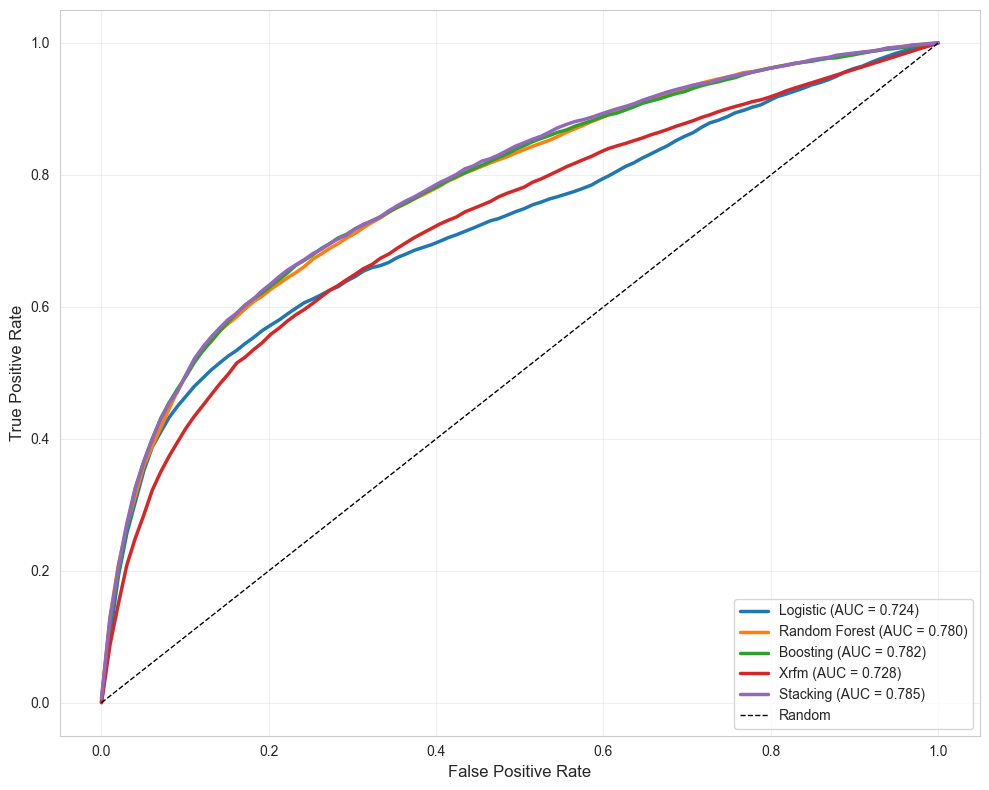

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {
    "logistic": "#1f77b4",
    "random_forest": "#ff7f0e",
    "boosting": "#2ca02c",
    "xrfm": "#d62728",
    "stacking": "#9467bd"
}

for model_name, folds in cv_results.items():
    all_fpr = []
    all_tpr = []
    
    for fold_data in folds:
        y_true = np.array(fold_data["y_true"])
        y_prob = np.array(fold_data["y_prob"])
        
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
    
    # Average ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    
    for fpr, tpr in zip(all_fpr, all_tpr):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    
    mean_tpr /= len(folds)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    ax.plot(mean_fpr, mean_tpr, 
            color=colors.get(model_name, "gray"),
            linewidth=2.5,
            label=f"{model_name.replace('_', ' ').title()} (AUC = {mean_auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_title('ROC Curves - All Models (Average across 5 folds)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Precision-Recall Curves

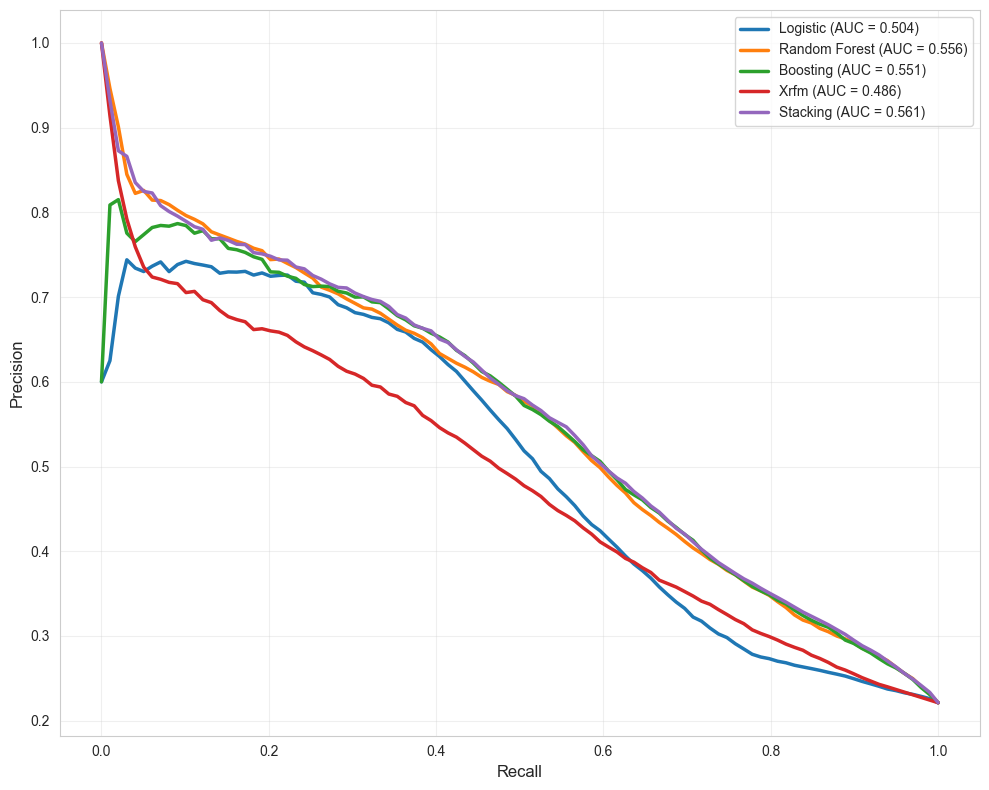

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

for model_name, folds in cv_results.items():
    all_precision = []
    all_recall = []
    
    for fold_data in folds:
        y_true = np.array(fold_data["y_true"])
        y_prob = np.array(fold_data["y_prob"])
        
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        all_precision.append(precision)
        all_recall.append(recall)
    
    # Average PR curve
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    
    for precision, recall in zip(all_precision, all_recall):
        mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1])
    
    mean_precision /= len(folds)
    mean_pr_auc = auc(mean_recall, mean_precision)
    
    ax.plot(mean_recall, mean_precision,
            color=colors.get(model_name, "gray"),
            linewidth=2.5,
            label=f"{model_name.replace('_', ' ').title()} (AUC = {mean_pr_auc:.3f})")

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
#ax.set_title('Precision-Recall Curves - All Models (Average across 5 folds)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Performance Comparison (Bar Charts)

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1856339758.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=45, ha='right')
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1856339758.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=45, ha='right')
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1856339758.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=45, ha='right')
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1856339758.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

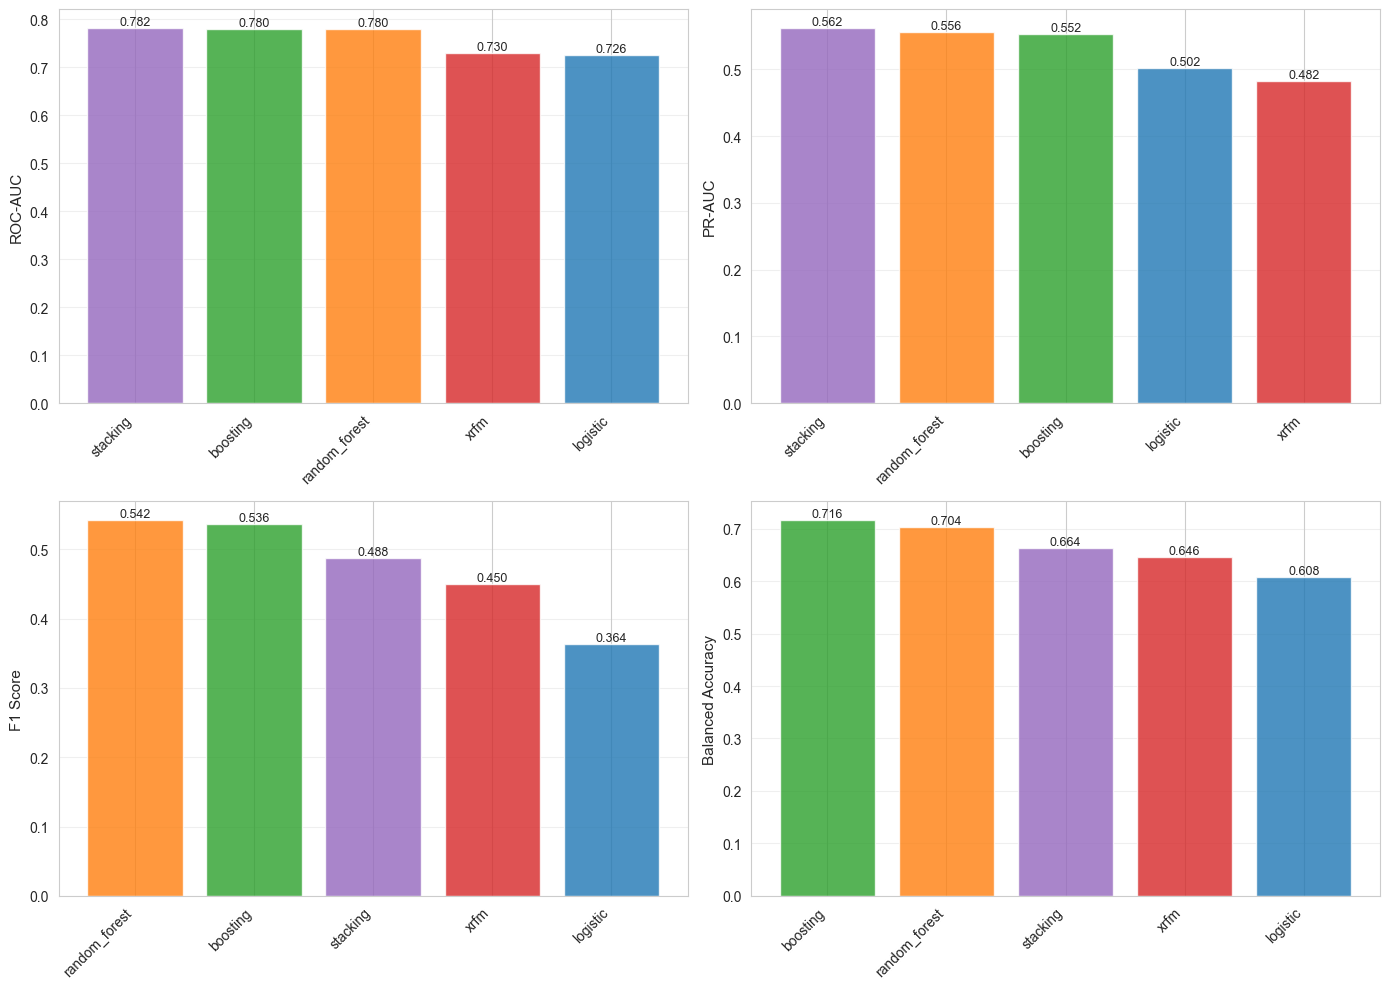

In [18]:
# Prepare data for plotting
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1', 'balanced_accuracy']
df_means = df_folds.groupby('model')[metrics_to_plot].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

titles = {
    'roc_auc': 'ROC-AUC',
    'pr_auc': 'PR-AUC',
    'f1': 'F1 Score',
    'balanced_accuracy': 'Balanced Accuracy'
}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Sort by metric value
    df_plot = df_means.sort_values(metric, ascending=False)
    
    bars = ax.bar(df_plot['model'], df_plot[metric], 
                  color=[colors.get(m, 'gray') for m in df_plot['model']],
                  alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel(titles[metric], fontsize=11)
    #ax.set_title(f'{titles[metric]} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticklabels(df_plot['model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Cross-Validation Stability (Box Plots)

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1851596856.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_folds, x='model', y='roc_auc', ax=axes[0], palette=colors)
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1851596856.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/1851596856.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_folds, x='model', y='pr_auc', ax=axes[1], palette=colors)
/var/folders/f9/2b84

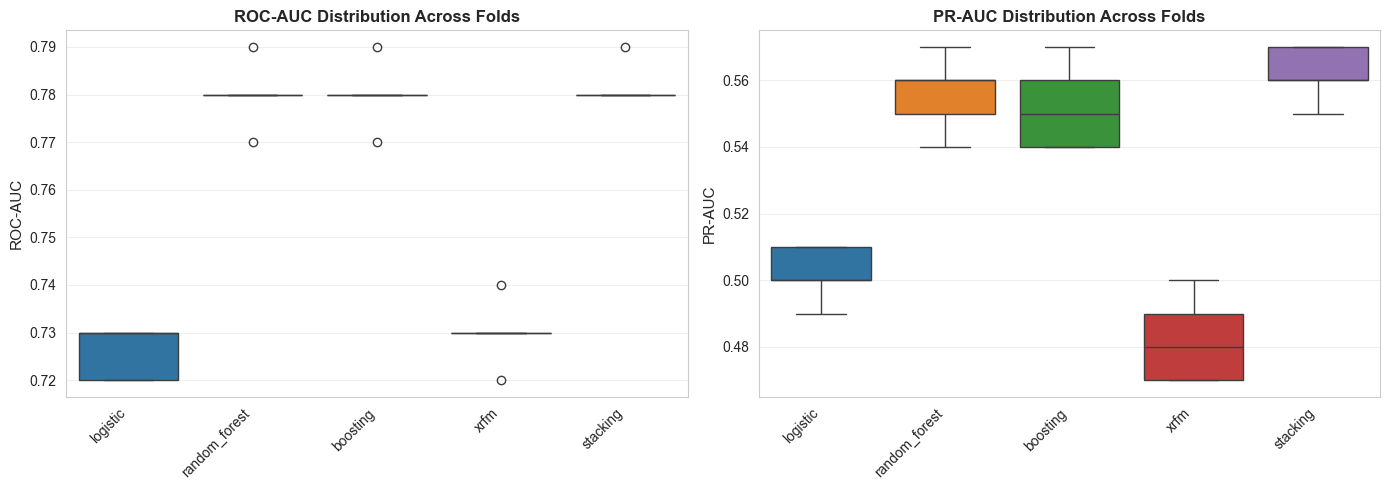

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC across folds
sns.boxplot(data=df_folds, x='model', y='roc_auc', ax=axes[0], palette=colors)
axes[0].set_title('ROC-AUC Distribution Across Folds', fontsize=12, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('ROC-AUC', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# PR-AUC across folds
sns.boxplot(data=df_folds, x='model', y='pr_auc', ax=axes[1], palette=colors)
axes[1].set_title('PR-AUC Distribution Across Folds', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('PR-AUC', fontsize=11)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/cv_stability.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Training Time Comparison

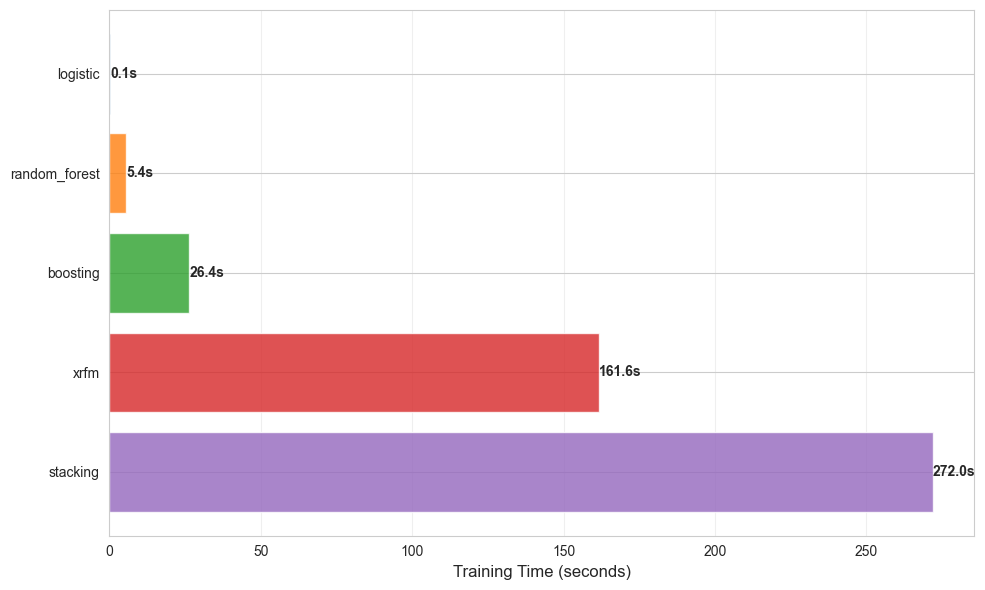

In [20]:
df_time = df_folds.groupby('model')['time_sec'].mean().sort_values(ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df_time['model'], df_time['time_sec'],
               color=[colors.get(m, 'gray') for m in df_time['model']],
               alpha=0.8)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}s',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Training Time (seconds)', fontsize=12)
#ax.set_title('Average Training Time per Fold', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/training_time.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Performance vs Time Trade-off

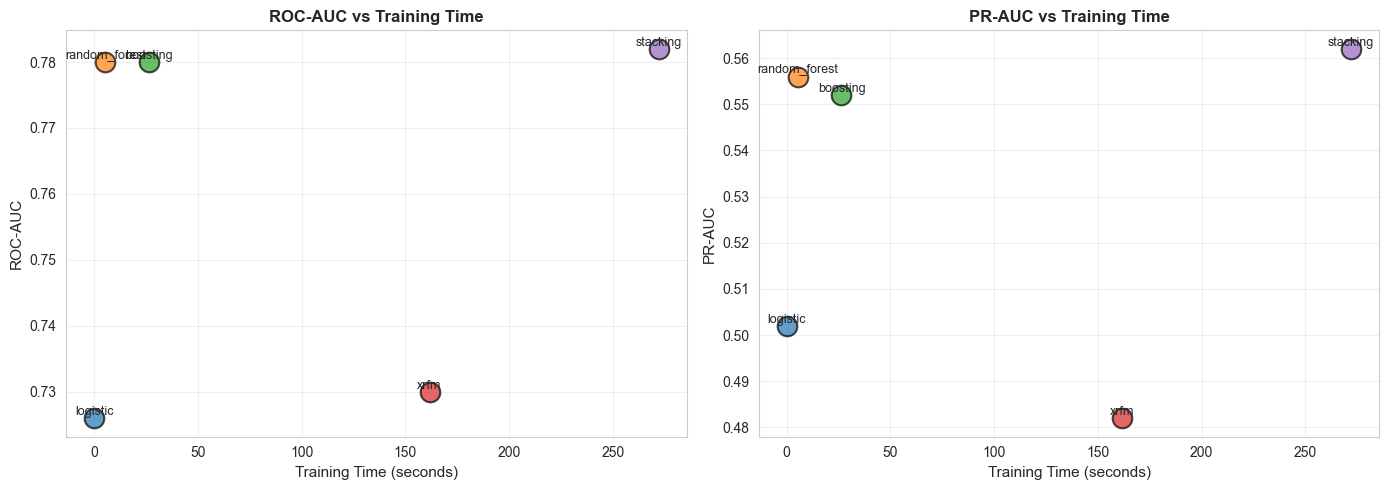

In [21]:
df_tradeoff = df_folds.groupby('model').agg({
    'roc_auc': 'mean',
    'pr_auc': 'mean',
    'time_sec': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC vs Time
for idx, row in df_tradeoff.iterrows():
    axes[0].scatter(row['time_sec'], row['roc_auc'], 
                   s=200, color=colors.get(row['model'], 'gray'),
                   alpha=0.7, edgecolors='black', linewidth=1.5)
    axes[0].annotate(row['model'], 
                    (row['time_sec'], row['roc_auc']),
                    fontsize=9, ha='center', va='bottom')

axes[0].set_xlabel('Training Time (seconds)', fontsize=11)
axes[0].set_ylabel('ROC-AUC', fontsize=11)
axes[0].set_title('ROC-AUC vs Training Time', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# PR-AUC vs Time
for idx, row in df_tradeoff.iterrows():
    axes[1].scatter(row['time_sec'], row['pr_auc'], 
                   s=200, color=colors.get(row['model'], 'gray'),
                   alpha=0.7, edgecolors='black', linewidth=1.5)
    axes[1].annotate(row['model'], 
                    (row['time_sec'], row['pr_auc']),
                    fontsize=9, ha='center', va='bottom')

axes[1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1].set_ylabel('PR-AUC', fontsize=11)
axes[1].set_title('PR-AUC vs Training Time', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/performance_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Calibration: Log Loss & Brier Score

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/2510613969.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_calib['model'], rotation=45, ha='right')
/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_29731/2510613969.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_brier['model'], rotation=45, ha='right')


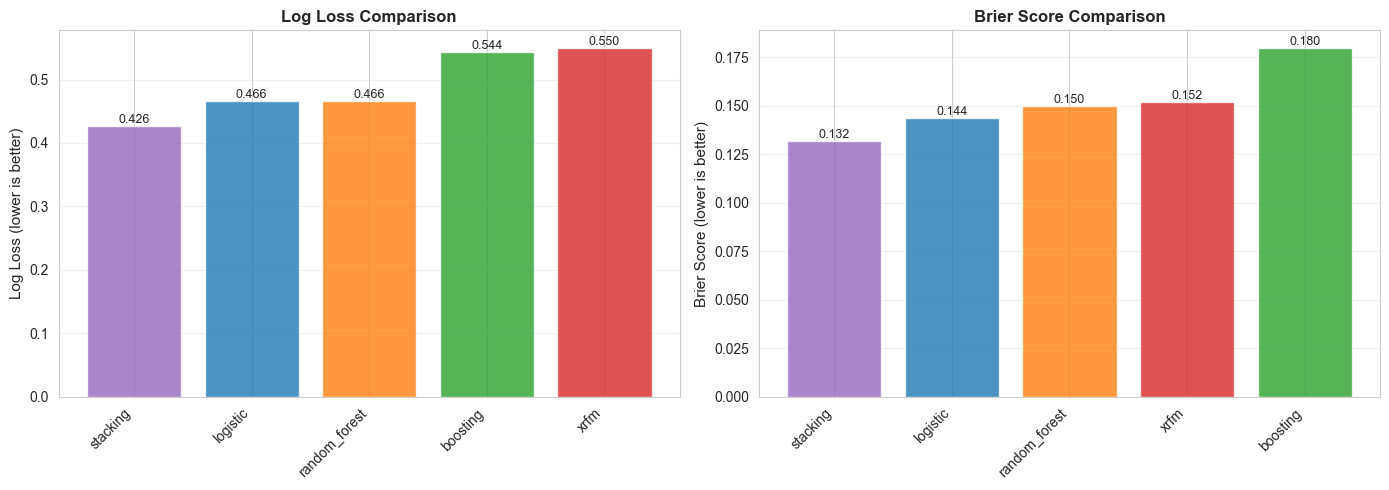

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_calib = df_folds.groupby('model')[['log_loss', 'brier']].mean().sort_values('log_loss').reset_index()

# Log Loss
bars = axes[0].bar(df_calib['model'], df_calib['log_loss'],
                   color=[colors.get(m, 'gray') for m in df_calib['model']],
                   alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('Log Loss (lower is better)', fontsize=11)
axes[0].set_title('Log Loss Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(df_calib['model'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Brier Score
df_brier = df_folds.groupby('model')[['brier']].mean().sort_values('brier').reset_index()
bars = axes[1].bar(df_brier['model'], df_brier['brier'],
                   color=[colors.get(m, 'gray') for m in df_brier['model']],
                   alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

axes[1].set_ylabel('Brier Score (lower is better)', fontsize=11)
axes[1].set_title('Brier Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(df_brier['model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/calibration_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Summary Table

In [23]:
# Create comprehensive summary table
summary_table = df_folds.groupby('model').agg({
    'roc_auc': ['mean', 'std'],
    'pr_auc': ['mean', 'std'],
    'f1': ['mean', 'std'],
    'log_loss': ['mean', 'std'],
    'time_sec': 'mean'
}).round(4)

summary_table.columns = ['_'.join(col) if col[1] else col[0] for col in summary_table.columns]
summary_table = summary_table.sort_values('roc_auc_mean', ascending=False)

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY (5-fold CV)")
print("="*80)
summary_table


MODEL PERFORMANCE SUMMARY (5-fold CV)


,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std,log_loss_mean,log_loss_std,time_sec_mean
model,,,,,,,,,
stacking,0.782,0.0045,0.562,0.0084,0.488,0.0084,0.426,0.0055,272.0000
boosting,0.780,0.0071,0.552,0.0130,0.536,0.0089,0.544,0.0055,26.4000
random_forest,0.780,0.0071,0.556,0.0114,0.542,0.0130,0.466,0.0055,5.4400
xrfm,0.730,0.0071,0.482,0.0130,0.450,0.0122,0.550,0.0122,161.6000
logistic,0.726,0.0055,0.502,0.0084,0.364,0.0089,0.466,0.0055,0.1466
